# IMPLEMENTING A GPT MODEL FROM SCRATCH TO GENERATE TEXT

In [1]:
import torch
import torch.nn as nn
import tiktoken
import matplotlib.pyplot as plt

In [2]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

## 1 - GPT ARCHITECTURE : DUMMY GPT MODEL CLASS  
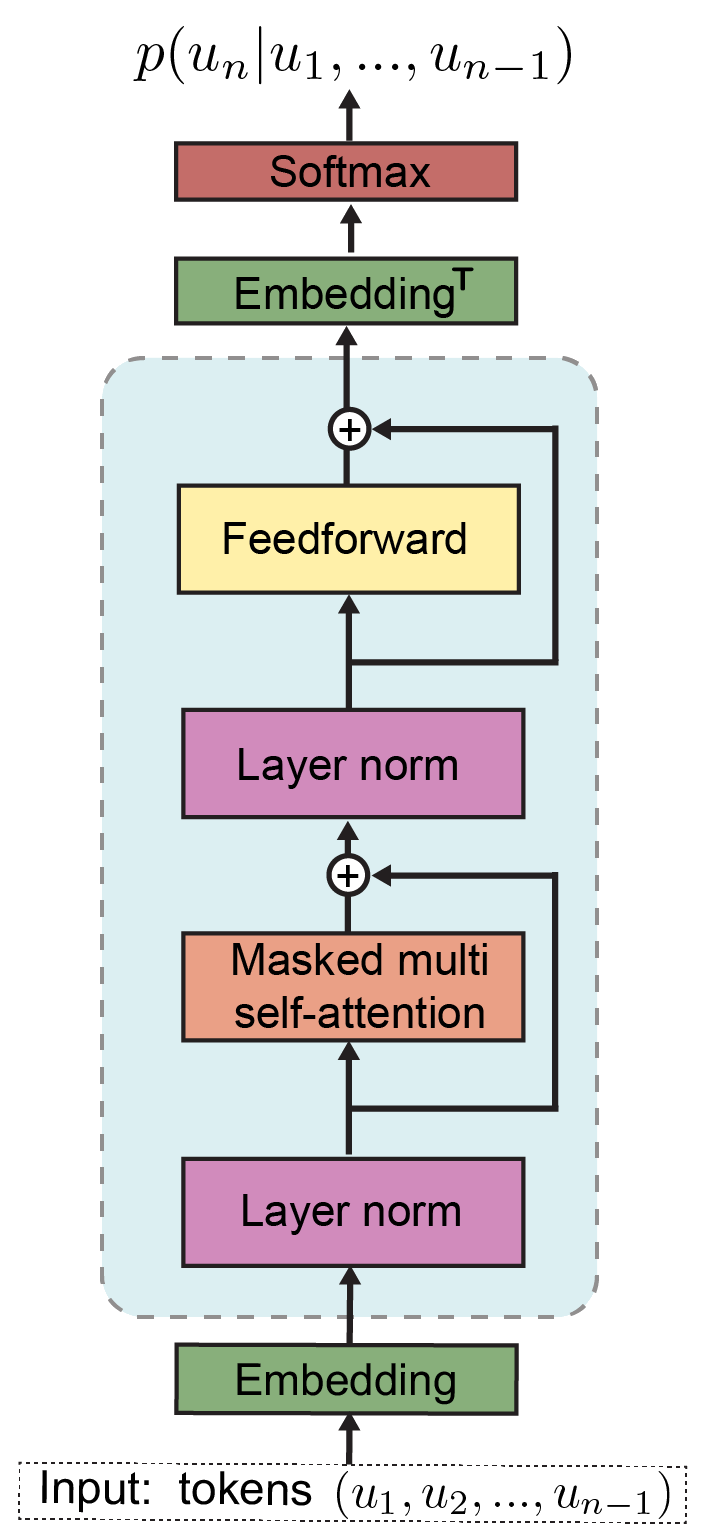

In [3]:
class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # the lookup table of ebedding  to get vector embedding for each token  >> size (vocabulary size * embedding size)
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
         # the lookup table of postional ebedding  to get postional embedding for each token >> size (context length * embedding size)
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"]) 
        #create a dropout to turn off some weights randomly according to drop rate
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        #the GPT MODEL 
        
        # Use a placeholder for TransformerBlock  >> which shown in the upper image 
        self.trf_blocks = nn.Sequential(
            *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        # Use a placeholder for LayerNorm
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])  #the normalization layes will build later
        self.out_head = nn.Linear(                        #this layer used to predict the next token 
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )
  # this function take the input to all stages of gpt2
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)  #create the embdding for the tokens 
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device)) #get postional embeding for each token 
        x = tok_embeds + pos_embeds  #get the info of postion andmeaning together
        x = self.drop_emb(x) #take the emeding vector and drop out some values 
        x = self.trf_blocks(x) # pass to transformar block
        x = self.final_norm(x) #then pass to normalization layer
        logits = self.out_head(x) #predict the output 
        return logits



**The DummyGPTModel class in this code defines a simplified version of a GPT-like model using PyTorch's neural network module (nn.Module).**
- The forward method describes the data flow through the model: it computes token and positional embeddings for the input indices, applies dropout
- processes the data through the transformer blocks, applies normalization, and finally produces logits with the linear output layer.

- **Step 1: Use a placeholder for TransformerBlock**

- **Step 2: Use a placeholder for LayerNorm**

In [4]:
class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x

In [5]:
# toknization the firts step 
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print("the token ids for each word in the batch")
print(batch)

the token ids for each word in the batch
tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [6]:
#CREATE AN INSTANCE OF DUMMYGPTMODE
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


**The output tensor has two rows corresponding to the two text samples. Each text sample consists of 4 tokens; each token is a 50,257-dimensional vector, which matches the size of the tokenizer's vocabulary**

## 2- GPT ARCHITECTURE : LAYER NORMALIZATION
**Layer Normalization is used to stabilize and speed up training in deep neural networks.**
-  It keeps activations at a consistent scale (zero mean, unit variance), which prevents exploding or vanishing gradients.
-  This makes optimization easier, especially in very deep models like Transformers. By adding learnable parameters (γ and β),
-  it preserves the model’s expressive power while ensuring numerical stability.

**Explanation with a simple example¶**

In [7]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5) #2 batches , 5 tokens for each one 
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU()) # 5 inputs , 6 outputs >only 2 layers nn 
out = layer(batch_example)
print(out)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


In [8]:
#Before we apply layer normalization to these outputs, let's examine the mean and variance
mean = out.mean(dim=-1, keepdim=True) #keppdim kep the same dim of the orginal tensor inestade of converting it to vector  
var = out.var(dim=-1, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


In [9]:
#Next, let us apply layer normalization to the layer outputs we obtained earlier.
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True) #almost 0 but not exactly 
var = out_norm.var(dim=-1, keepdim=True)
print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[9.9341e-09],
        [0.0000e+00]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [10]:
#To improve readability, we can also turn off the scientific notation when printing tensor values by setting sci_mode to False:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[0.0000],
        [0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


**Let's now encapsulate this process in a PyTorch module that we can use in the GPT model late**

In [11]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim)) 
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True) # calculate the mean for each row 
        var = x.var(dim=-1, keepdim=True, unbiased=False) #calulate the variance of each row , unbiased=False >> for calc  population  devide by n 
        norm_x = (x - mean) / torch.sqrt(var + self.eps) #The variable eps is added to the variance to prevent division by zero during normalization
        return self.scale * norm_x + self.shift 

**The scale and shift are two trainable parameters (of the same dimension as the input) that the LLM automatically adjusts during training if it is determined that doing so would improve the model's performance on its training task.**

- `This allows the model to learn appropriate scaling and shifting that best suit the data it is processing.`

In [12]:
#Let's now try the LayerNorm module in practice and apply it to the batch input:
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, unbiased=False, keepdim=True)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[-0.0000],
        [ 0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


**As we can see based on the results, the layer normalization code works as expected and normalizes the values of each of the two inputs such that they have a mean of 0 and a variance of 1:**

## GPT ARCHITECTURE : FEED FORWARD NEURAL NETWORK WITH GELU ACTIVATION

### GELU – Conclusion
GELU softly scales inputs using a Gaussian probability instead of hard thresholding like ReLU.

**Exact:**
$
\[
\text{GELU}(x) = x \cdot \Phi(x) = \frac{x}{2}\left(1 + \mathrm{erf}\left(\frac{x}{\sqrt{2}}\right)\right)
\$]

**Approximation (used in practice):**
$\[
\text{GELU}(x) \approx 0.5x\left(1 + \tanh\left(\sqrt{\frac{2}{\pi}}(x + 0.044715x^3)\right)\right)
\$]

It improves stability and performance in deep Transformer models.


In [13]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

### GELU VS RELU

### Why GELU instead of ReLU?

ReLU applies a hard threshold:
$\[
\text{ReLU}(x) = \max(0, x)
\$]
which completely discards all negative values.

GELU applies **soft gating**:
$\[
\text{GELU}(x) = x \cdot \Phi(x)
\$]
so small negative values are reduced, not removed.

**Why GELU is preferred in Transformers:**
- Smooth and fully differentiable (better gradients)
- Preserves information from small negative activations
- Works better with deep stacks and residual connections
- Empirically improves convergence and performance

ReLU is simple and fast, but GELU provides better stability and learning in deep Transformer models.


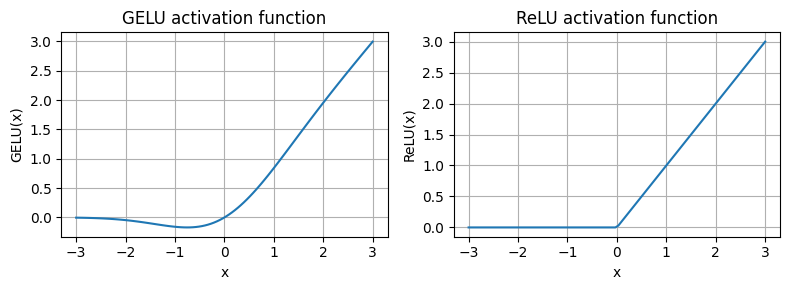

In [14]:
gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()


### the Feed-Forward Block (FFN)?
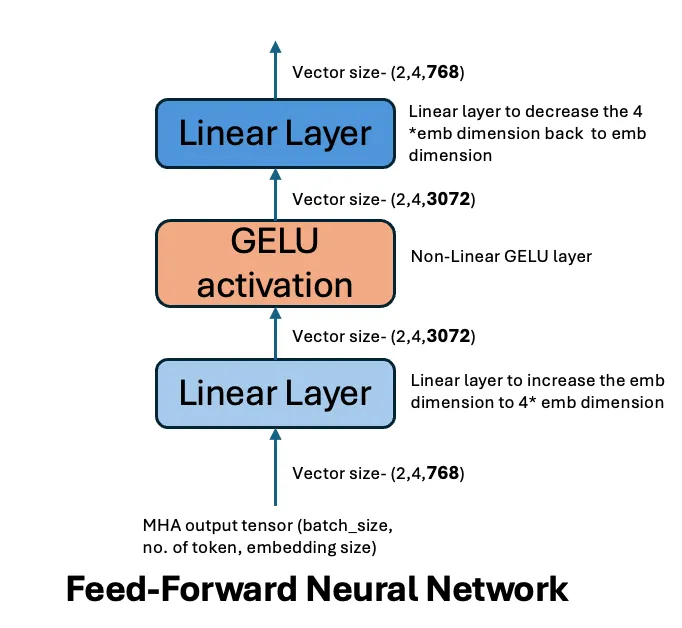

The feed-forward block gives the Transformer **non-linearity and per-token feature transformation**.

After attention mixes information across tokens, the FFN:
$\[
\text{FFN}(x) = W_2 \, \sigma(W_1 x + b_1) + b_2
\$]

**Why it is needed:**
- Adds non-linearity (attention alone is mostly linear)
- Transforms features **independently for each token**
- Increases model capacity and expressiveness
- Enables learning complex patterns after attention

Without the FFN, a Transformer would have limited modeling power and much weaker representations.


In [15]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), #layer1 >input 768 dim and output 4*768 like gpt2
            GELU(), #the activation function between them 
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]), #layer1 >input 4*768 dim and output 768 like gpt2
        )

    def forward(self, x):
        return self.layers(x)

**Let's use the GELU function to implement the small neural network module, FeedForward, that we will be using in the LLM's transformer block later:**

In [16]:
#GPT_CONFIG_124M >> have the embedding size which we will use 
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768) #eample 
out = ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


**The FeedForward module we implemented in this section plays a crucial role in enhancing the model's ability to learn from and generalize the data.**

- Although the input and output dimensions of this module are the same, it internally expands the embedding dimension into a higher-dimensional space through the first linear layer.

- This expansion is followed by a non-linear GELU activation, and then a contraction back to the original dimension with the second linear transformation.

**`such a design allows for the exploration of a richer representation space.`**

## GPT ARCHITECTURE : SHORTCUT CONNECTIONS
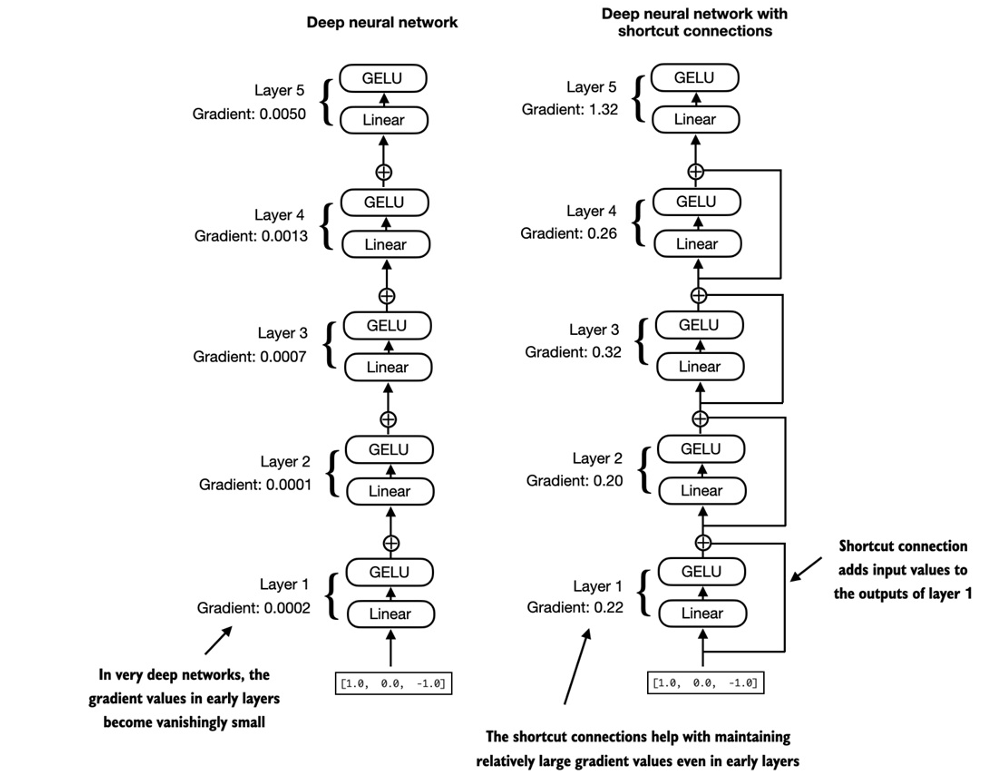


**Let us see how we can add shortcut connections to the forward method:**

In [17]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_sizes, use_shortcut):
        super().__init__()
        self.use_shortcut = use_shortcut
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_sizes[0], layer_sizes[1]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()),
            nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
        ]) # 5 layers neural network 

    def forward(self, x):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(x)
            # Check if shortcut can be applied
            if self.use_shortcut and x.shape == layer_output.shape:
                x = x + layer_output
            else:
                x = layer_output
        return x


In [18]:
#example without shortcut
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123) # specify random seed for the initial weights for reproducibility
model_without_shortcut = ExampleDeepNeuralNetwork(
layer_sizes, use_shortcut=False
)

**Next, we implement a function that computes the gradients in the the model's backward pass:**

In [19]:
def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])# >>the output of the previous nn

    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)
    
    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

**Let's now use the print_gradients function and apply it to the model without skip connections:**

In [20]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041653171182
layers.3.0.weight has gradient mean of 0.001398873864673078
layers.4.0.weight has gradient mean of 0.005049646366387606


**As we can see based on the output of the print_gradients function, the gradients become smaller as we progress from the last layer (layers.4) to the first layer (layers.0), which is a phenomenon called the vanishing gradient problem.**

In [21]:
#Let's now instantiate a model with skip connections and see how it compares:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNeuralNetwork(
layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694106817245483
layers.2.0.weight has gradient mean of 0.32896995544433594
layers.3.0.weight has gradient mean of 0.2665732502937317
layers.4.0.weight has gradient mean of 1.3258541822433472


**As we can see, based on the output, the last layer (layers.4) still has a larger gradient than the other layers.
However, the gradient value stabilizes as we progress towards the first layer (layers.0) and doesn't shrink to a vanishingly small value.**

##  ARCHITECTURE: CODING ATTENTION AND LINEAR LAYERS IN A TRANSFORMER BLOCK

**we should add the multi head attention class from the previos notebook**

In [22]:
class MultiHeadAttention(nn.Module):
    def __init__(self,d_in,d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"
       # intial values 
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        # intialize the weight matrices 
        self.W_K = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_Q = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_V = nn.Linear(d_in, d_out, bias=qkv_bias)

        # to applay the mask of causal attention
        self.register_buffer("mask",torch.triu(torch.ones(context_length, context_length),diagonal=1))
        # to applay dropout 
        self.dropout = nn.Dropout(dropout)

        # this is like a mixer to mix the weights from the heads together 
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
    def forward(self,x):
        b, num_tokens, d_in = x.shape

        keys = self.W_K(x) # Shape: (batch, num_tokens, d_out)
        queries = self.W_Q(x)
        values = self.W_V(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        # calculate the attention weights 
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        # dropout to enhance training 
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim) >> to get d_out 
        context_vec = (attn_weights @ values).transpose(1, 2) 

        # Combine heads, where self.d_out = self.num_heads * self.head_dim >> final context vector for each word 
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        # the mixer will mex the result of each head with other to consider all relations that each head collect
        context_vec = self.out_proj(context_vec) 


        return context_vec

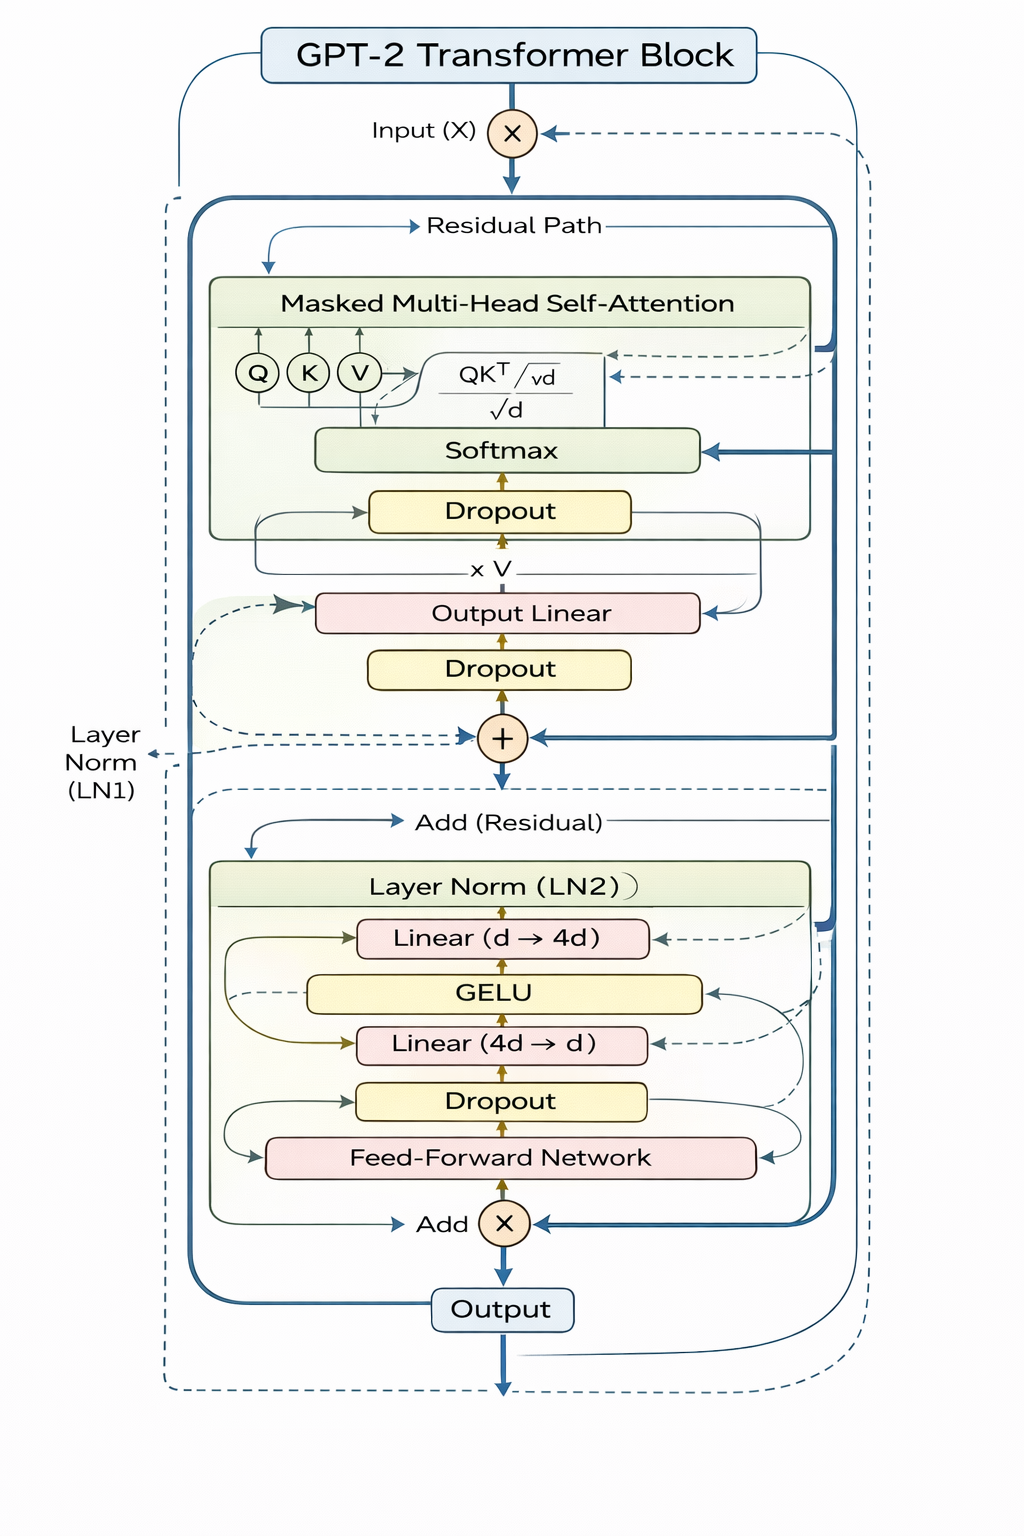

In [23]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            # cfg in the first line of the page the gpt-2 parameters
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])
        self.ff = FeedForward(cfg) # the feed forward after attention 
        self.norm1 = LayerNorm(cfg["emb_dim"])# normalization before attention 
        self.norm2 = LayerNorm(cfg["emb_dim"]) # normalization after feed forward  

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x # >> the inputs 
        x = self.norm1(x) #1 the normalization layer 
        # multi head attention 
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size] 
        x = self.drop_shortcut(x) #the dropout 
        x = x + shortcut  # Add the original input back x = data_after_attention + input embedings

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

**now lets make sure its working**

In [24]:
torch.manual_seed(123)
x = torch.rand(2, 4, 768) #A
block = TransformerBlock(GPT_CONFIG_124M)
output = block(x)
print("Input shape:", x.shape)
print("Output shape:", output.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


**The preservation of shape throughout the transformer block architecture is not incidental but a crucial aspect of its design.**
- This design enables its effective application across a wide range of sequence-to-sequence tasks.
- where each output vector directly corresponds to an input vector, maintaining a one-to-one relationship.

**However, the output is a context vector that encapsulates information from the entire input sequence.**
- This means that while the physical dimensions of the sequence (length and feature size) remain unchanged as it passes through the transformer block
- `the content of each output vector is re-encoded to integrate contextual information from across the entire input sequence.`

## GPT ARCHITECTURE : ENTIRE GPT MODEL ARCHITECTURE IMPLEMENTATION

In [25]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"]) # 1- the ebedding layer  
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"]) # 2- the postional embedding layer 
        self.drop_emb = nn.Dropout(cfg["drop_rate"]) #3- the dropout before transformer block 
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]) #4-  12 transformer blocks each one has a 12 attention heads 
        
        self.final_norm = LayerNorm(cfg["emb_dim"]) # 5- the final normalization layer aftter transformer block 
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        ) # finally the output layer which used to give the probabilty matrix for the next token for each input token 

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x) # logits matrix 
        return logits

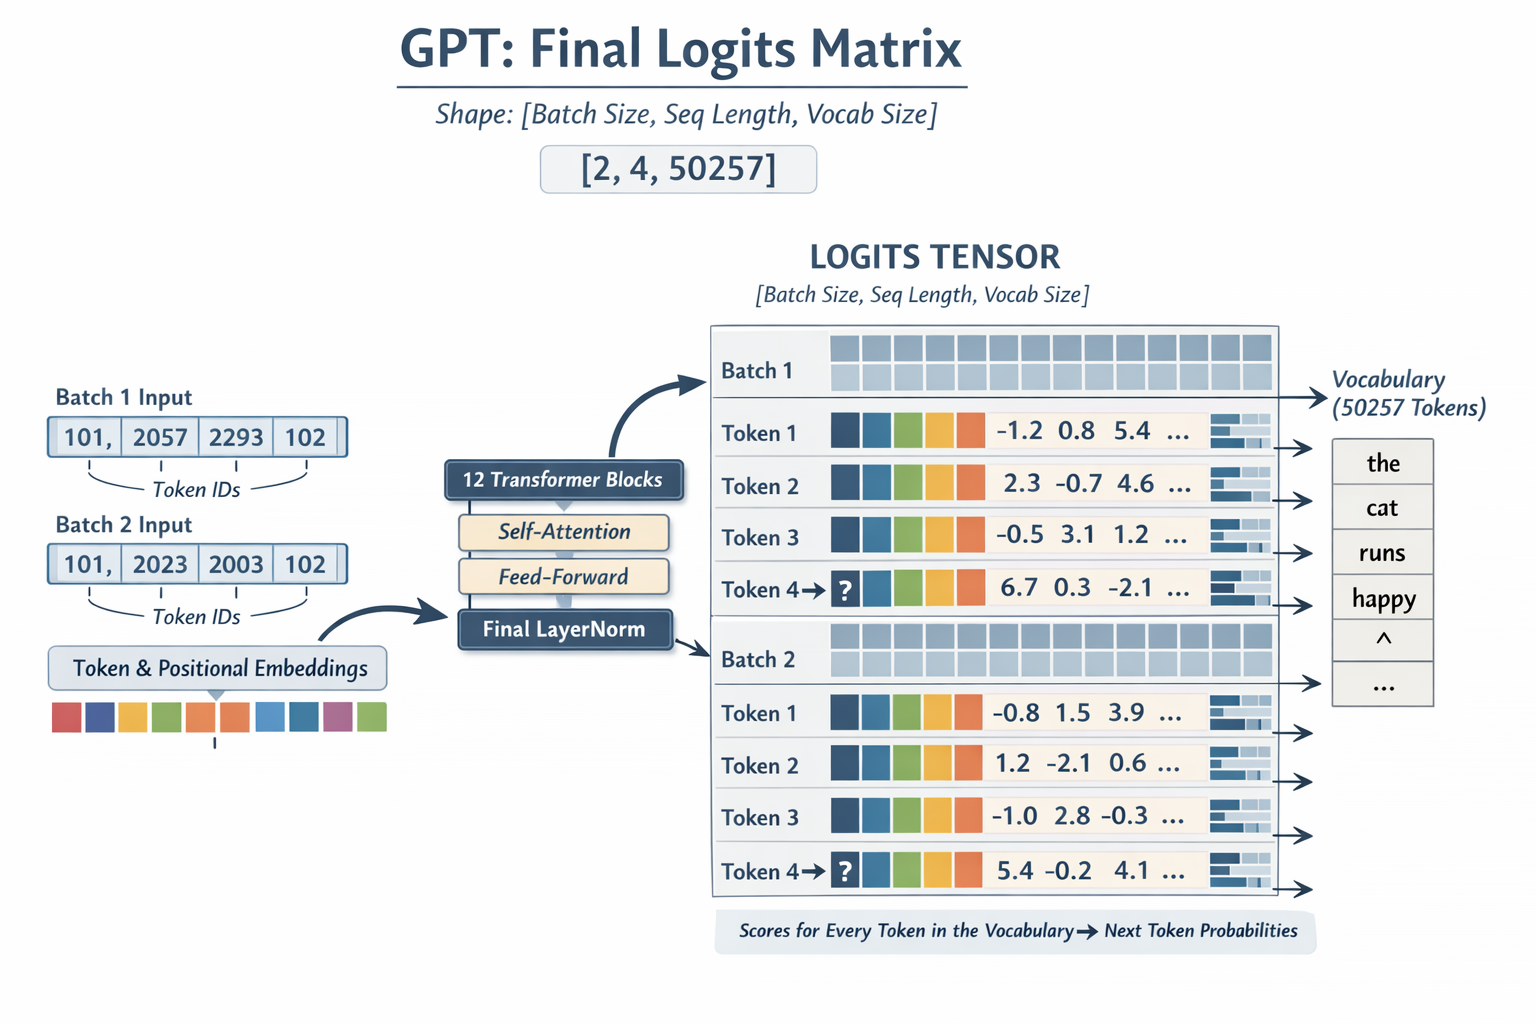

**now lets see example**

In [26]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1527, -0.5039, -0.8502,  ...,  0.0877,  0.5718, -0.3429],
         [ 0.7497,  0.0502,  0.0263,  ...,  0.0523, -0.4993, -0.1765],
         [-0.9096,  0.4484, -0.1124,  ...,  0.7928,  0.4427, -0.0017]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1317,  0.4324, -0.1969,  ...,  0.8463,  0.2101,  0.1708],
         [ 1.0335,  1.0049, -0.2195,  ...,  0.6317,  0.3796, -0.2901],
         [-0.1305,  0.3932,  0.3877,  ...,  1.2653, -0.1867, -0.0026]]],
       grad_fn=<UnsafeViewBackward0>)


### number of parameters in gpt-2

In [27]:
#Using the numel() method, short for "number of elements," we can collect the total number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


**Earlier, we spoke of initializing a 124 million parameter GPT model, so why is the actual number of parameters 163 million, as shown in the preceding code output?**

`The reason is a concept called weight tying that is used in the original GPT-2 architecture, which means that the original GPT-2 architecture is reusing the weights from the token embedding layer in its output layer.`

`To understand what this means, let's take a look at the shapes of the token embedding layer and linear output layer that we initialized on the model via the GPTModel earlier:`

In [28]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


**As we can see based on the print outputs, the weight tensors for both these layers have the same shape:**

`The token embedding and output layers are very large due to the number of rows for the 50,257 in the tokenizer's vocabulary. Let's remove the output layer parameter count from the total GPT-2 model count according to the weight tying:`

In [29]:
total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")

Number of trainable parameters considering weight tying: 124,412,160


**As we can see, the model is now only 124 million parameters large, matching the original size of the GPT-2 model.**

In [30]:
#the memory size of the model 163 m parameters  
total_size_bytes = total_params * 4 #each parameter take d bytes 
total_size_mb = total_size_bytes / (1024 * 1024) #B
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


## GPT ARCHITECTURE : GENERATING TEXT FROM OUTPUT TOKENS

**steps** 
- 1- `idx` is a (batch, n_tokens) array of indices in the current context

-  2- Crop current context if it exceeds the supported context size E.g., if LLM supports only 5 tokens, and the context size is 10 then only the last 5 tokens are used as context

- 3- Focus only on the last time step, so that (batch, n_token, vocab_size) becomes (batch, vocab_size)

-  4- probas has shape (batch, vocab_size)

- 5- idx_next has shape (batch, 1)

- 6: Append sampled index to the running sequence, where idx has shape (batch, n_tokens+1)

In [37]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        #logits = logits[all_batches, last raw, all columns ] 
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

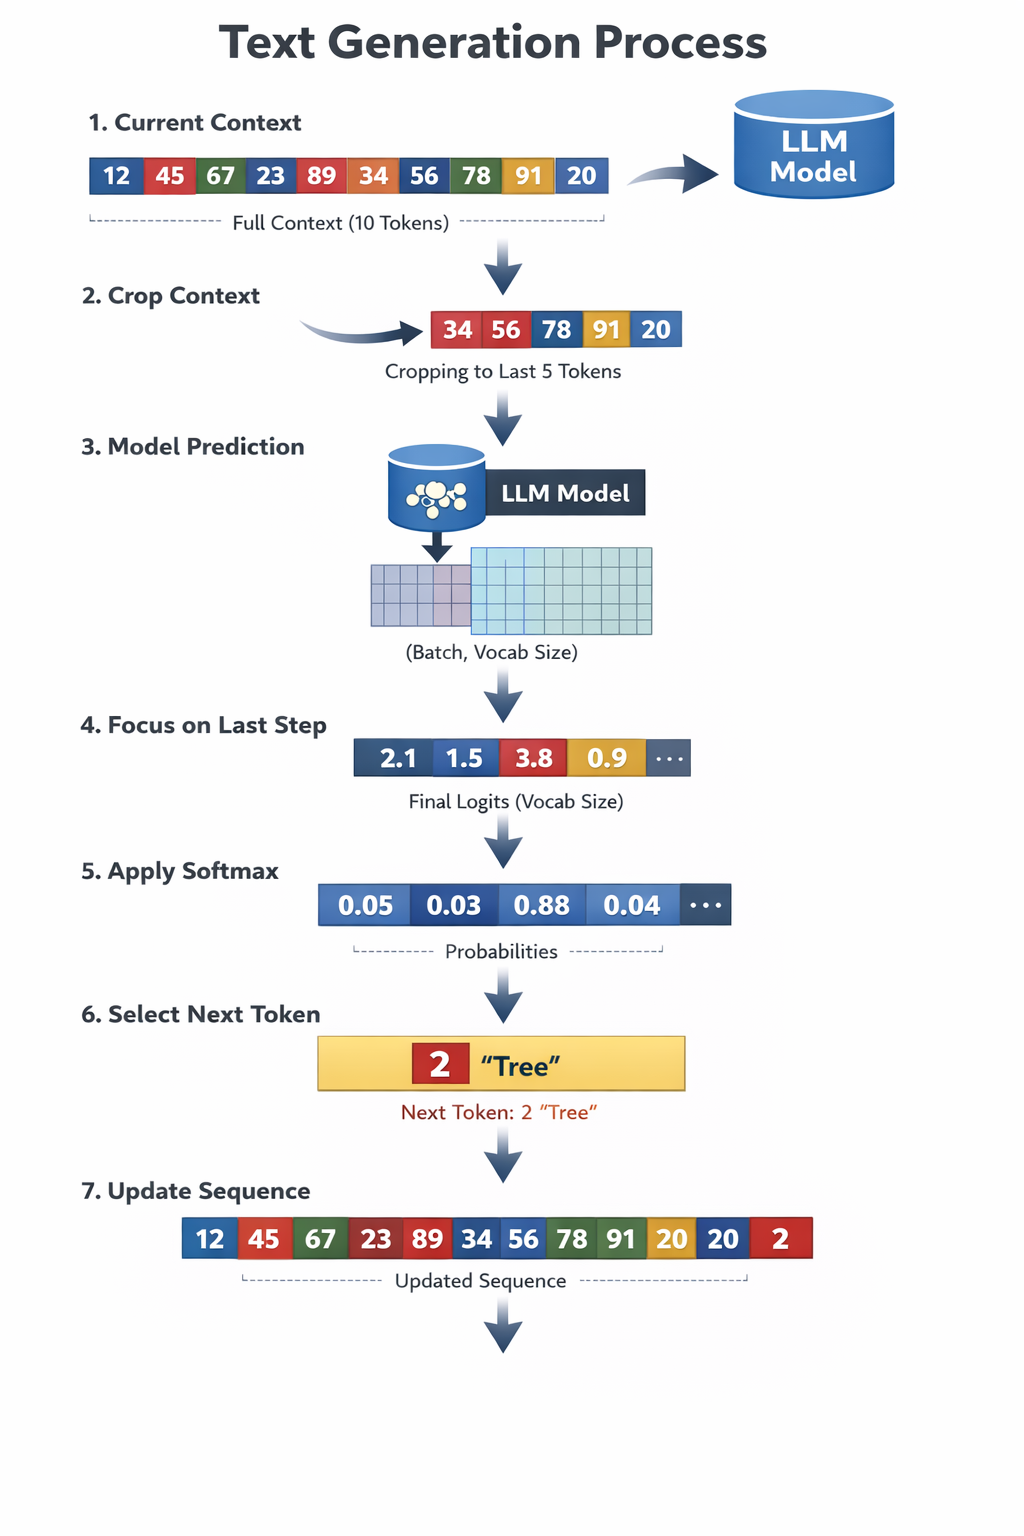

**First, we encode the input context into token IDs:**

In [34]:
tokenizer = tiktoken.get_encoding("gpt2")
#the input text
start_context = "Hello, I am"
#toknization by byte pair encoder of gpt_2
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0) 
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


**Next, we put the model into .eval() mode, which disables random components like dropout, which are only used during training, and use the generate_text_simple function on the encoded input tensor:**
- `We disable dropout since we are not training the model`

In [38]:
model.eval() 
out = generate_text_simple(
model=model, #the gpt-2 model we created 
idx=encoded_tensor ,# the input 4 tokens
max_new_tokens=6 ,#genrate new 6 tokens 
context_size=GPT_CONFIG_124M["context_length"] #use the default cotext size which is 1024
)
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 29739,   554]])
Output length: 10


**Using the .decode method of the tokenizer, we can convert the IDs back into text:**

In [39]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswick Exit In


**The reason why the model is unable to produce coherent text is that we haven't trained it yet.**

**So far, we just implemented the GPT architecture and initialized a GPT model instance with initial random weights.**